Problem 1 : Write a program (please attach a printout) which implements the error function and, if needed, its gradient, produces a plot of the function obtained, evaluate the value of the training error and of the test error, analyse the occurrence of overfitting/underfitting varying the number of neurons $N$ and of the parameters $\mu$.

In [1]:
%matplotlib nbagg
from scipy.optimize import basinhopping
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time

<IPython.core.display.Javascript object>


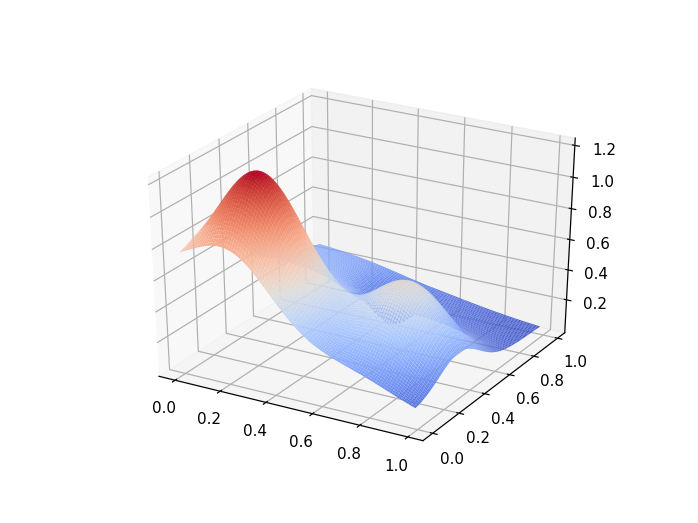

In [3]:
franke_function = lambda x1,x2 : 0.75*np.exp(((-(9*x1 - 2)**2)/4) - ((9*x2 - 2)**2)/4) \
+ 0.75*np.exp(((-(9*x1 + 1)**2)/49) - (9*x2 + 1)/10) + 0.5*np.exp(((-(9*x1 - 7)**2)/4) \
- ((9*x2 - 3)**2)/4) - 0.2*np.exp(((-(9*x1 - 4)**2) - (9*x2 - 7)**2))
X = np.arange(0, 1, 0.01) 
Y = np.arange(0, 1, 0.01)
X,Y = np.meshgrid(X, Y)  
f = franke_function(X,Y) 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, f, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0)
plt.show() 

Generating the dataset:

In [4]:
x1 = np.random.uniform(0, 1, 100) 
x2 = np.random.uniform(0, 1, 100)
noise = np.random.uniform(0, 0.01, len(x1)) 
y = franke_function(x1,x2) + noise

Let's split the data in training and test set:

In [ ]:
x1_train = x1[0:80]
x2_train = x2[0:80]
y_train = y[0:80]

x1_test = x1[80:100]
x2_test = x2[80:100]
y_test = y[80:100]

Defining a plotting function:

In [5]:
def plot_(y_hat, x1, x2):
    X1,X2 = np.meshgrid(x1, x2)   
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X1, X2, y_hat , rstride=1, cstride=1,
                    cmap=cm.coolwarm, antialiased=True)
    plt.show()    
    return '.'

We have to solve some non-convex problems using three type of optimization algorithm already implemented in SciPy:

1) quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS)

2) conjugate gradient algorithm by Polak, Polyak and Ribiere (CG-PPR)

3) stochastic global optimization algorithm Basin-Hopping (BH)

The first one use approximate the hessian matrix using first derivative. Can be expensive in really high dimensional space and we can't ensure the convergence to the global optimum. The CG-PPR method uses also only first derivatives and no global convergence is not avaiable for non-convex problems. Basin-Hopping is a stochastic global optimization algorithm that at every step compute a random perturbation of the coordinates coupled with a local minimization.
Below we have many optimization routines with the mean squared error for the test and the training set. I choose the number of neurons $N =  \{1,2\}$ and the regularization parameter $\mu = \{0.01, 2, 20\}$ with a Gaussian kernel.
We evaluate the model on the mean squarred error: $MSE =\frac{1}{n}\sum_{i = 1}^{n} ( \hat{y}-y  )^{2}$ 


$N = 1 \,\,\,\, \mu = 0.01$

In [ ]:
function_1 = lambda c, x1, x2, y,mu: 0.5 * (np.sum(((c[0] * (np.exp(-((x1 - c[1])**2 
                        + (x2 - c[2]) ** 2)))) - y) ** 2)) + mu * np.linalg.norm(c)

mse = lambda c, x1, x2, y: np.sum(((c[0] * (np.exp(-((x1 - c[1])**2 
                        + (x2 - c[2]) ** 2)))) - y) ** 2) / len(x1)

In [ ]:
mu = [0.0, 0.001, 0.01, 0.1, 1, 10]

In [ ]:
for reg in mu:
    start = timer()
    opt_result = minimize(function_1, x0=(0,0,0), args=(x1_train, x2_train, y_train, reg))
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    print("test error = "+str(mse(opt_result.x,x1_test,x2_test,y_test)))
    print("training error = "+str(mse(opt_result.x,x1_train,x2_train,y_train)))

Now the CG-PPR:

In [ ]:
for reg in mu:
    start = timer()
    opt_result = minimize(function_1 ,x0=(0,0,0),args=(x1_train, x2_train, y_train, reg), 
                      method = 'CG')
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    print("test error = "+str(mse(opt_result.x,x1_test,x2_test,y_test)))
    print("training error = "+str(mse(opt_result.x,x1_train,x2_train,y_train)))

For the BH algorithm we should choose the local optimizer. In this case I choose the BFGS: 

In [ ]:
for reg in mu:
    start = timer()
    minimizer_kwargs = {"method": "BFGS","args":(x1_train, x2_train, y_train, reg)}
    start = timer()
    opt_result = basinhopping(function_1, x0=(0,0,0), minimizer_kwargs=minimizer_kwargs,
                          niter=200)
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    print("test error = "+str(mse(opt_result.x,x1_test,x2_test,y_test)))
    print("training error = "+str(mse(opt_result.x,x1_train,x2_train,y_train)))

Let's increase the number of neurons:

In [ ]:
function_2 = lambda c, x1, x2, y,mu: 0.5 * (np.sum(((c[0] * (np.exp(-((x1 - c[1])**2 
                        + (x2 - c[2]) ** 2))))+ (c[3] * (np.exp(-((x1 - c[4])**2 
                        + (x2 - c[5]) ** 2))))- y) ** 2)) + mu * np.linalg.norm(c)
mse_2 = lambda c, x1, x2, y: np.sum(((c[0] * (np.exp(-((x1 - c[1])**2 
                        + (x2 - c[2]) ** 2)))) + 
                      (c[3] * (np.exp(-((x1 - c[4])**2 
                        + (x2 - c[5]) ** 2))))- y) ** 2) / len(x1)

In [ ]:
for reg in mu:
    start = timer()
    minimizer_kwargs = {"method": "BFGS","args":(x1_train, x2_train, y_train, reg)}
    start = timer()
    opt_result = minimize(function_2 ,x0=(0,0,0,0,0,0),args=(x1_train,x2_train,y_train, reg))
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    print("test error = "+str(mse_2(opt_result.x,x1_test,x2_test,y_test)))
    print("training error = "+str(mse_2(opt_result.x,x1_train,x2_train,y_train)))

In [ ]:
for reg in mu:
    start = timer()
    opt_result = minimize(function_1 ,x0=np.zeros(6),args=(x1_train, x2_train, y_train, reg), 
                      method = 'CG')
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    print("test error = "+str(mse_2(opt_result.x,x1_test,x2_test,y_test)))
    print("training error = "+str(mse_2(opt_result.x,x1_train,x2_train,y_train)))

In [ ]:
for reg in mu:
    minimizer_kwargs = {"method": "BFGS","args":(x1_train, x2_train, y_train, reg)}
    start = timer()
    opt_result = basinhopping(function_1, x0=np.zeros(6), minimizer_kwargs=minimizer_kwargs,
                          niter=200)
    end = timer()
    print('\nRegularizer = '+str(reg))
    print('Objective function value = '+str(opt_result.fun), 'Time = '+str(end-start))
    print("test error = "+str(mse_2(opt_result.x,x1_test,x2_test,y_test)))
    print("training error = "+str(mse_2(opt_result.x,x1_train,x2_train,y_train)))

From the results we can observe that the test error is always below the training error, indicating that our model is too simple and we should add more neurons in order to reduce the bias.